
image 1/1 /Users/amaljoe/Desktop/Workspace/IITB/NLP/OCR_with_LLMs/data/iam_form.png: 640x448 29 words, 21.0ms
Speed: 1.5ms preprocess, 21.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)
Results saved to detected


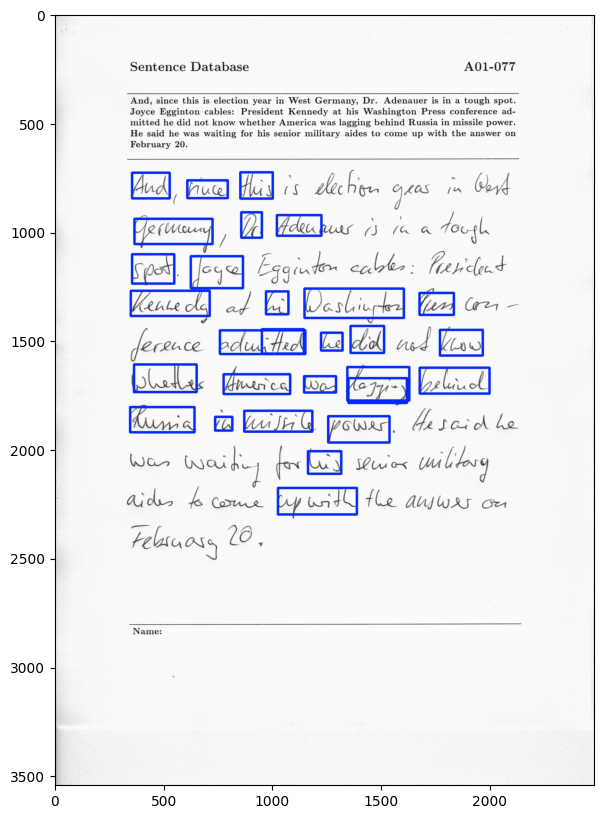

In [5]:
from ultralytics import YOLO
from huggingface_hub import hf_hub_download
from matplotlib import pyplot as plt

# Load the weights from our repository
model_path = hf_hub_download(local_dir=".",
                             repo_id="armvectores/yolov8n_handwritten_text_detection",
                             filename="best.pt")
model = YOLO(model_path)

# Load test blank
test_blank_path = hf_hub_download(local_dir=".",
                                  repo_id="armvectores/yolov8n_handwritten_text_detection",
                                  filename="test_blank.png")

# Do the predictions
res = model.predict(source="data/iam_form.png", project='.',name='detected', exist_ok=True, save=True, show=False, show_labels=False, show_conf=False, conf=0.5, )

plt.figure(figsize=(15,10))
plt.imshow(plt.imread('detected/iam_form.jpg'))
plt.show()